In [64]:
import os
# for the model
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# for data manipulation and graphing
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from IPython.display import display, HTML

tf.random.set_seed(42) # set seed for reproducibility
tf.debugging.set_log_device_placement(False)

## Data preprocessing

In [2]:
# load the dataset
# connectium
# original_dataset = pd.read_csv("C:/Users/franc/pasantia_IA/datasets/data_connectium.csv")
# sip
original_dataset = pd.read_csv("C:/Users/franc/pasantia_IA/datasets/data_sip.csv")

# show the original data
original_dataset.head()

,Task_ID,Priority,Project_ID,Project_code,Category,Total_developers,TaskPerformance,DeveloperPerformance,Hours_estimate,Hours_logged,Difference
0,7963,4,9,PC9,Release,1,-8.95,-5.95,3.0,11.95,8.95
1,7963,4,9,PC9,Release,1,-8.95,NaN,3.0,11.95,8.95
2,12609,1,6,PC6,Enhancement,1,-8.94,-8.94,35.0,43.94,8.94
3,13397,1,5,PC5,Testing,1,-8.92,-8.92,14.0,22.92,8.92
4,6063,1,9,PC9,Enhancement,1,8.82,NaN,35.0,26.18,8.82


In [3]:
# show the metadata
original_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4267 entries, 0 to 4266
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Task_ID               4267 non-null   int64  
 1   Priority              4267 non-null   int64  
 2   Project_ID            4267 non-null   int64  
 3   Project_code          4267 non-null   object 
 4   Category              4267 non-null   object 
 5   Total_developers      4267 non-null   int64  
 6   TaskPerformance       4267 non-null   float64
 7   DeveloperPerformance  3830 non-null   float64
 8   Hours_estimate        4267 non-null   float64
 9   Hours_logged          4267 non-null   float64
 10  Difference            4267 non-null   float64
dtypes: float64(5), int64(4), object(2)
memory usage: 366.8+ KB


In [4]:
# drop all the unnecessary columns
clean_dataset = original_dataset[[
    'Task_ID',
    'Project_ID',
    'Priority',
    'Category',
    'Total_developers',
    'Hours_estimate',
    'Hours_logged',
]]

# desnormalizing data
clean_dataset = pd.get_dummies(clean_dataset, columns=['Category'])
clean_dataset = clean_dataset.astype(int)

In [5]:
clean_dataset.head()

,Task_ID,Project_ID,Priority,Total_developers,Hours_estimate,Hours_logged,Category_Bug,Category_Enhancement,Category_Release,Category_Testing
0,7963,9,4,1,3,11,0,0,1,0
1,7963,9,4,1,3,11,0,0,1,0
2,12609,6,1,1,35,43,0,1,0,0
3,13397,5,1,1,14,22,0,0,0,1
4,6063,9,1,1,35,26,0,1,0,0


In [6]:
clean_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4267 entries, 0 to 4266
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Task_ID               4267 non-null   int32
 1   Project_ID            4267 non-null   int32
 2   Priority              4267 non-null   int32
 3   Total_developers      4267 non-null   int32
 4   Hours_estimate        4267 non-null   int32
 5   Hours_logged          4267 non-null   int32
 6   Category_Bug          4267 non-null   int32
 7   Category_Enhancement  4267 non-null   int32
 8   Category_Release      4267 non-null   int32
 9   Category_Testing      4267 non-null   int32
dtypes: int32(10)
memory usage: 166.8 KB


### Data sampling

Split the data into train, test and validate samples to fit and evaluate the model

The percentage of each one will be

- 60% training
- 20% testing
- 20% validating

In [7]:
train_dataset, test_dataset = train_test_split(clean_dataset, test_size=0.20)

# validation_dataset, test_dataset = train_test_split(temp_test_dataset, test_size=0.50)

print("Samples shape")
print(f"    Train: {train_dataset.shape}")
print(f"    Test: {test_dataset.shape}")
# print(f"    Validation: {validation_dataset.shape}")

Samples shape
    Train: (3413, 10)
    Test: (854, 10)


### Data analysis

Calculate the correlation and other statistics on the train dataset

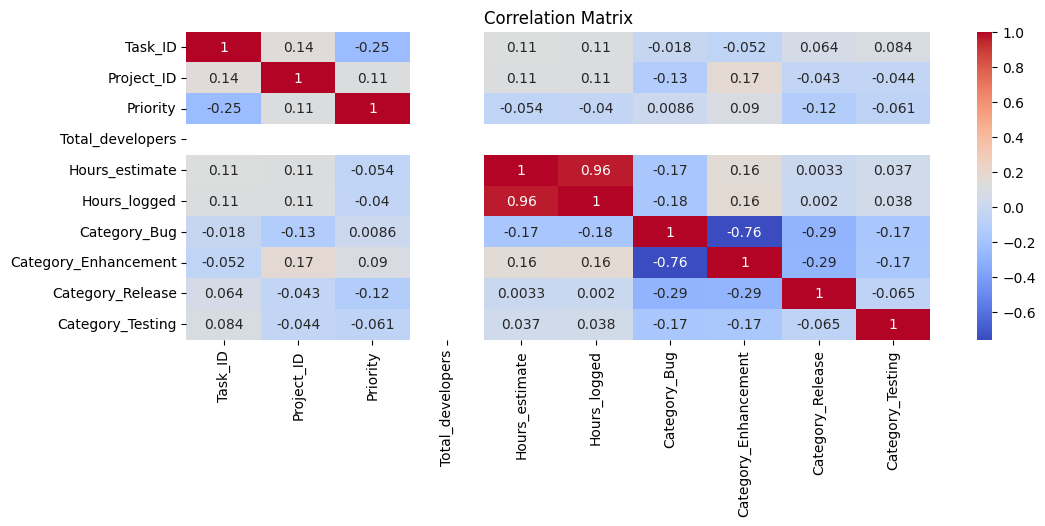

In [8]:
# correlation between the features and the target

correlation_matrix = clean_dataset.corr()
correlation_matrix['Hours_logged'].sort_values(ascending=False)

# plot the correlation matrix
plt.figure(figsize=(12, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [9]:
# another interesting statistics like the count, mean, std, min, quartiles and max, all per feature
train_stats = train_dataset.describe()
train_stats.pop("Hours_logged")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Task_ID,3413.0,7205.862291,2878.501693,2134.0,4880.0,7001.0,9006.0,14355.0
Project_ID,3413.0,5.080574,4.287063,2.0,2.0,2.0,9.0,18.0
Priority,3413.0,2.258131,1.778271,1.0,1.0,1.0,3.0,10.0
Total_developers,3413.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
Hours_estimate,3413.0,4.702901,9.529874,0.0,1.0,2.0,7.0,260.0
Category_Bug,3413.0,0.436273,0.495995,0.0,0.0,0.0,1.0,1.0
Category_Enhancement,3413.0,0.426311,0.494613,0.0,0.0,0.0,1.0,1.0
Category_Release,3413.0,0.101670,0.302258,0.0,0.0,0.0,0.0,1.0
Category_Testing,3413.0,0.035746,0.185683,0.0,0.0,0.0,0.0,1.0


### Feature prediction

The label "Hours Logged" is the actual goal for our model, we will remove it from every sample and keep it apart

In [10]:
train_label = train_dataset.pop('Hours_logged')
test_label = test_dataset.pop('Hours_logged')

### Data normalization/Scaling

Subtract the mean of the training data and divide by the standard deviation of the training data.

In [12]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

# is some of the data is NaN, fill it with 1
if normed_train_data['Total_developers'].isna().any():
    normed_train_data['Total_developers'] = normed_train_data['Total_developers'].fillna(1)
    normed_test_data['Total_developers'] = normed_test_data['Total_developers'].fillna(1)

In [13]:
# show a part of the normalized data
normed_train_data.head()

,Task_ID,Project_ID,Priority,Total_developers,Hours_estimate,Category_Bug,Category_Enhancement,Category_Release,Category_Testing
1316,-1.013327,-0.718575,1.541874,1.0,-0.178691,1.136558,-0.861909,-0.336368,-0.19251
2096,-0.540164,-0.718575,1.541874,1.0,-0.178691,1.136558,-0.861909,-0.336368,-0.19251
2445,0.485717,-0.718575,-0.707502,1.0,-0.388557,1.136558,-0.861909,-0.336368,-0.19251
108,-0.417531,0.914245,-0.707502,1.0,0.975574,-0.879592,1.159875,-0.336368,-0.19251
790,0.926572,-0.252055,-0.707502,1.0,0.765708,-0.879592,-0.861909,2.972061,-0.19251


## Building the Neural Network Model

### Firts Model
Two hidden layers with 50 neurons each

Learning rate at 0.001

In [47]:
def build_first_model_two_hidden_layers():
    model = Sequential(name = "FirstModelTwoHiddenLayers")

    # Input layer
    model.add(Dense(10, input_shape = (normed_train_data.shape[1],)))

    # Hidden layer 
    model.add(Dense(50, Activation('relu'), name='hidden_layer_1'))
    model.add(Dense(50, Activation('relu'), name='hidden_layer_2'))

    # Output layer 
    model.add(Dense(1))

    learnig_rate = 0.001
    optimizer = optimizers.RMSprop(learning_rate=learnig_rate)
    model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy', 'mae', 'mse'])

    return model

### Second Model

Three hidden layers with 32, 64 and 128 neurons, respectively

Learning rate at 0.01

In [43]:
def build_second_model_three_hidden_layers():
    model = Sequential(name = "SecondModelThreeHiddenLayers")

    # Input layer
    model.add(Dense(10, input_shape = (normed_train_data.shape[1],)))

    # Hidden layer 
    model.add(Dense(32, Activation('relu'), name='hidden_layer_1'))
    model.add(Dense(64, Activation('relu'), name='hidden_layer_2'))
    model.add(Dense(128, Activation('relu'), name='hidden_layer_3'))

    # Output layer 
    model.add(Dense(1))

    learnig_rate = 0.01
    optimizer = optimizers.RMSprop(learning_rate=learnig_rate)
    model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy', 'mae', 'mse'])

    return model

### Third Model

Five hidden layers, all with 64 neurons

Learning rate at 0.001

In [44]:
def build_third_model_five_hidden_layers():
    model = Sequential(name = "ThirdModelFiveHiddenLayers")

    # Input layer
    model.add(Dense(10, input_shape = (normed_train_data.shape[1],)))

    # Hidden layer 
    model.add(Dense(64, Activation('relu'), name='hidden_layer_1'))
    model.add(Dense(64, Activation('relu'), name='hidden_layer_2'))
    model.add(Dense(64, Activation('relu'), name='hidden_layer_3'))
    model.add(Dense(64, Activation('relu'), name='hidden_layer_4'))
    model.add(Dense(64, Activation('relu'), name='hidden_layer_5'))

    # Output layer 
    model.add(Dense(1))

    learnig_rate = 0.01
    optimizer = optimizers.RMSprop(learning_rate=learnig_rate)
    model.compile(
        loss='mse',
        optimizer=optimizer,
        metrics=['accuracy', 'mae', 'mse']
    )

    return model

### Fourth Model

Recurrent Neural Network

In [45]:
def build_fourth_model_LSTM_hidden_layers():
    model = Sequential(name = "FourthModelLSTMHiddenLayers")

    model.add(Reshape(
        (normed_train_data.shape[1], 1),
        input_shape=(normed_train_data.shape[1],)
    ))

    model.add(SimpleRNN(128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
  
    model.add(Dense(1, Activation('linear')))

    learnig_rate = 0.0001
    optimizer = optimizers.Adam(learning_rate=learnig_rate)
    model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy', 'mae', 'mse'])

    return model    

### Fith Model

Support Vector Machine

In [15]:
def build_model_svc():
    parameters = {'kernel':('linear', 'rbf')}
    svr = SVR()
    return GridSearchCV(svr, parameters)

### Choose the model

In [16]:
def choose_model(model_type, model_number):
    if (model_type == 'Neuronal Network'):
        if (model_number == 1):
            return build_first_model_two_hidden_layers()
        elif (model_number == 2):
            return build_second_model_three_hidden_layers()
        elif (model_number == 3):
            return build_third_model_five_hidden_layers()
        elif (model_number == 4):
            return build_fourth_model_LSTM_hidden_layers()
    else:
        return build_model_svc()


Save checkpoints during training

In [48]:
# checkpoint_path = r".\checkpoint_logs\connectium\data.ckpt"
checkpoint_path = r".\checkpoint_logs\sip\data.ckpt"

# Create a callback that saves the model's weights
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_loss', # or val_accuracy if you have it.
                                                 save_best_only=True, # Default false. If you don't change the file name then the output will be overritten at each step and only the last model will be saved.
                                                 save_weights_only=True, # True => model.save_weights (weights and no structure, you need JSON file for structure), False => model.save (saves weights & structure)
                                                 verbose=0,
)

## Model training

In [49]:
def training_neural_network_model(model, n_folds):
    kFold = KFold(n_splits=n_folds)

    histories = []

    print("Summary of the model")
    model.summary()

    i = 0

    for train_index, val_index in kFold.split(normed_train_data):
        train_data_i, val_data_i = normed_train_data.iloc[train_index], normed_train_data.iloc[val_index]
        train_label_i, val_label_i = train_label.iloc[train_index], train_label.iloc[val_index]


        # for first model - is winning
        epochs = 64
        batch_size = 10

        print("\nTraining the model - K Validation: ", i, "\n")

        history = model.fit(
            train_data_i,
            train_label_i,
            batch_size=batch_size,  
            epochs=epochs, 
            verbose=0,
            shuffle=True,
            steps_per_epoch = int(train_data_i.shape[0] / batch_size),
            validation_data=(val_data_i, val_label_i),
            callbacks=[
                tfdocs.modeling.EpochDots(),
                ckpt_callback,
            ]
        )

        histories.append(history)
        i = i + 1
    
    return histories
    

In [19]:
def training_support_vector_machine_model(model):
    model.fit(normed_train_data, train_label)
    
    history = pd.DataFrame({
        'Accuracy': [model.score(normed_test_data, test_label)],
        'Best params hash': [model.best_params_],
        'Best score': [model.best_score_],
        'Best estimator': [model.best_estimator_],
    })

    print(history)
    return history

In [51]:
%%time

model = choose_model('Neuronal Network', 1)
# model = choose_model('Support Vector Machine', 0)

histories = training_neural_network_model(model, 4)
# history = training_support_vector_machine_model(model)


Summary of the model
Model: "FirstModelTwoHiddenLayers"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                100       
                                                                 
 hidden_layer_1 (Dense)      (None, 50)                550       
                                                                 
 hidden_layer_2 (Dense)      (None, 50)                2550      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 3251 (12.70 KB)
Trainable params: 3251 (12.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Training the model - K Validation:  0 




Epoch: 0, accuracy:0.2082,  loss:38.1265,  mae:3.1797,  mse:38.1265,  val

### Predicted and real values

Here we will see the first 10 rows of the predicted data, comparing it with the real one

## Evaluating the model

The metrics we choose to evaluate the model were **Mean Abs. Error** and **Mean squarred Error**

### Showing the resulting metrics from the training

In [73]:
def evaluating_neural_network_model(histories):
    i = 0
    history_datasets = []
    for history in histories:
        history_dataset = pd.DataFrame(history.history)
        history_dataset['epoch'] = history.epoch
        history_dataset['fold'] = i
        i = i+1
        history_datasets.append(history_dataset)

        
    history_dataset = pd.concat(history_datasets)

    print("Resume of the training history model")
    display(HTML(history_dataset.head().to_html()))

    history_datasets_csv = history_dataset
    history_datasets_csv.to_csv(r"./outputs/neural_network/history_sip.csv", index=False)  

    fold_histories = {
        f'Fold {i}': history for i, history in enumerate(histories)
    }

    print("Plotting the training history model per epoch")

    plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
    plotter.plot(fold_histories, metric="mse")
    plt.ylabel('MSE [Metric]')
    plt.show()


In [39]:
def evaluating_svc_model(history, test_predictions):
    history['MSE'] = [mean_squared_error(test_label, test_predictions)],
    
    print(history)

    history.to_csv(r"./outputs/svr/history_sip.csv", index=False)   

    # saving the results
    pd.DataFrame({
        'Logged': test_label,
        'Predicted': test_predictions
    }).to_csv(r"./outputs/svr/history_sip.csv", index=False)

Resume of the training history model


,loss,accuracy,mae,mse,val_loss,val_accuracy,val_mae,val_mse,epoch,fold
0,38.126549,0.208235,3.179735,38.126549,8.899705,0.256440,2.013897,8.899706,0,0
1,8.144868,0.258140,1.892097,8.144868,6.179929,0.274005,1.706320,6.179929,1,0
2,7.144482,0.265987,1.777994,7.144482,6.945799,0.251756,1.833751,6.945799,2,0
3,7.176236,0.278541,1.772668,7.176236,6.156051,0.284543,1.684500,6.156049,3,0
4,6.966365,0.269910,1.753719,6.966365,6.221526,0.296253,1.666773,6.221525,4,0


Plotting the training history model per epoch


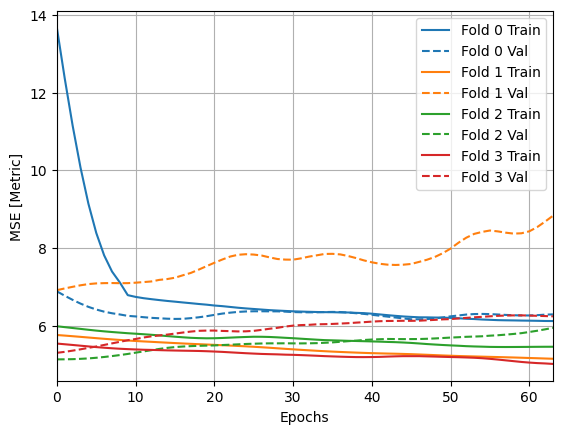

In [74]:
evaluating_neural_network_model(histories)
# evaluating_svc_model(history, test_predictions)

## Predicting the data

In [77]:
example_batch = normed_train_data[:5]
example_result = model.predict(example_batch)

print("Example for the first 5 samples")
print("Predicted Hours Logged")
print(example_result)
    
print("Real Hours Logged")
print(train_label[:5])

test_predictions = model.predict(normed_test_data)

1/1 [==============================] - 0s 27ms/step
Example for the first 5 samples
Predicted Hours Logged
[[ 3.0527854]
 [ 2.930684 ]
 [ 1.8740517]
 [10.728476 ]
 [15.760679 ]]
Real Hours Logged
1316     4
2096     2
2445     2
108      6
790     15
Name: Hours_logged, dtype: int32
27/27 [==============================] - 0s 2ms/step


In [78]:
test_predictions = model.predict(normed_test_data).flatten()

predictions_dataset = pd.DataFrame({
    'Logged': test_label,
    'Predicted': test_predictions
})

# test_predictions_to_csv = pd.DataFrame(test_predictions).to_csv(r"./outputs/neural_network/test_predictions_sip.csv", index=False)
# test_label_to_csv = pd.DataFrame(test_label).to_csv(r"./outputs/neural_network/test_label_sip.csv", index=False)

predictions_dataset_csv = predictions_dataset
predictions_dataset_csv.to_csv(r"./outputs/neural_network/predictions_sip.csv", index=False)

27/27 [==============================] - 0s 2ms/step


Predictions VS. True Values for Hours Logged

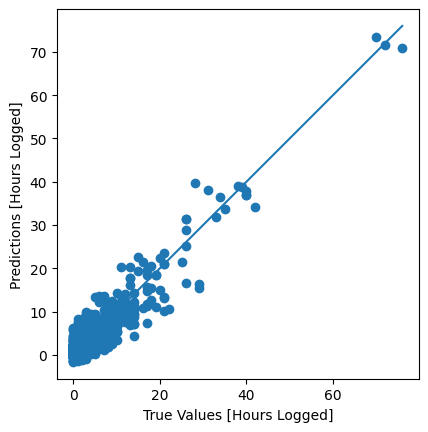

In [76]:
axes = plt.axes(aspect='equal')
plt.scatter(test_label, test_predictions)
plt.xlabel('True Values [Hours Logged]')
plt.ylabel('Predictions [Hours Logged]')
# calculate the limit
max_value = max(test_label.max(), test_predictions[0].max())
_ = plt.plot([0, max_value], [0, max_value])